<font face='Avenir' size=5><p style="text-align:center">Employment Survey EDA</p></font>

<font face='Avenir' size=3>Using our data from a declarative surveys on jobs and employment, we'd like to answers the questions below, and explain how we came to these conclusions.<font><br>


$\circ$ <font face='Avenir' size=3>1. What is the distribution of expected net income, in relation to current net income?</font><br>
$\circ$ <font face='Avenir' size=3>2. What is the correlation between the desire to earn more and the possibility of a longer commute?</font><br>
$\circ$ <font face='Avenir' size=3>3. What key factor determines the tendency to move closer to work?</font><br>
$\bullet$ Rephrased: What's the most relevant factor influencing willingness to move closer to work?<br>


<font size=2> Original wording</font><br>
<font size=1>1. What is the distribution of the expected net income in relation to the current net income 
(charts + conclusions)?</font><br>
<font size=1>2. What is the correlation between the desire to earn more and the possibility to commute longer 
(further away from home).</font><br>
<font size=1>3. What is the key factor that determines the tendency to move closer to the work place 
(what is the most relevant factor influencing the will to move home closer work)?</font><br>

<u>0. Data Prep and Imports</u>

The given file was for Microsoft SQL Server, which isn't exaclty like SQLite3.  
Some conversions to the DDL were done, and the _.sql_ was split into two:
  - One text file to define the table
  - One text file to populate the table

SQLiteStudio 3.1.1 was used to test, and inspect structure.
***


Inserting Data INTO the Jobs table  
Findings/Modifications
1. remove N before all strings : `replace N' with '`
2. add semi-colon after all insert statements : `replace \n\n with ;\n\n`    
3. add INTO after the word INSERT : `replace INSERT with INSERT INTO`
4. open files as read not read-binary : therefore, data is a string when passed to `.execute`
5. remember to use `.commit()` on conneciton after cursor execution : otherwise nothing is written to the table
5. Must split commands : use `.split('\n')`


In [1]:
# imports 01
import collections
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
# imports 02
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report

from scipy.stats import spearmanr

from itertools import combinations

import numpy as np

In [3]:
# imports 03
import seaborn as sns
sns.set(style='ticks', color_codes=True)

In [4]:
# imports 04 - NOT USED
# from rpy2.robjects import r
# from rpy2.robjects.packages import importr

In [4]:
# prep 01 "makedb02.py"
import sqlite3
import os

IMPORT_ROWS = False

def make_table(dbname='survey.db',tablename='Jobs'):
    ddltext = open("CREATE_only.txt")
    ddldata = ddltext.read()
    ddltext.close()
    ex_q = "Select name From sqlite_master Where type='table'"
    con = sqlite3.connect(dbname)
    cur = con.cursor()

    # check table existence
    cur.execute(ex_q)
    all_tables = cur.fetchall()
    
    # check for empty list first, otherwise index error
    if all_tables:
        #print(all_tables)
        #if tablename not in all_tables[0]:
        if tablename not in [x[0] for x in all_tables]:
            cur.execute(ddldata)
    else:
        cur.execute(ddldata)
        
    cur.close()
    # We return the connection so that another cursor can be used
        # if necessary.
    con.commit()
    return con

def data_prep():
    all_data_file = open("sql_data_only.txt",'r')
    all_data = all_data_file.read()
    all_data_file.close()
    single_commands_list = all_data.split('\n')
    return single_commands_list


def populate_table(db_conn, command_list):
    cur = db_conn.cursor()
    for command in command_list:
        # When we split on \n, we also get empty strings for the
            # lines between commands.
        if command:
            cur.execute(command)
    cur.close()
    db_conn.commit()


# ------ Main ----- #
con_to_db = make_table()

commands = data_prep()

if IMPORT_ROWS:
    populate_table(con_to_db, commands)

con_to_db.close()

# results in 3692 rows in the Jobs database

Jobs Table Columns, in order
- The column names, order, and this list wil be used many times.
- It's also a good reference for later on, when things are abbreviated

In [6]:
# prep 02

tcol = ["[id]",
"[Are you looking for a job?]",
"[Q13-C22 - Do you work currently? - Answer]",
"[How far do you live from current or previous work - less than 5 km]",
"[How far are you able to commute - less than 5 km]",
"[How far do you live from current or previous work - 5 -10 km]",
"[How far are you able to commute - less than 5 - 10 km]",
"[How far do you live from current or previous work - 11 - 20 km]",
"[How far are you able to commute - less than 11 - 20 km]",
"[How far do you live from current or previous work - 21 - 50 km]",
"[How far are you able to commute - less than 21 - 50 km]",
"[How far do you live from current or previous work - 51 - 100 km]",
"[How far are you able to commute - less than 51 - 100 km]",
"[How far do you live from current or previous work - more than 100 km]",
"[How far are you able to commute - more than 100 km]",
"[What is your current or previous monthly net salary - up to 1000 EUR]",
"[How much would you like to get monthly - up to 1000 EUR]",
"[What is your current or previous monthly net salary - 1001 - 1500 EUR]",
"[How much would you like to get monthly - 1001 - 1500 EUR]",
"[What is your current or previous monthly net salary - 2001 - 3000 EUR]",
"[How much would you like to get monthly - 2001 - 3000 EUR]",
"[What is your current or previous monthly net salary - 3001 - 4000 EUR]",
"[How much would you like to get monthly - 3001 - 4000 EUR]",
"[What is your current or previous monthly net salary - 4001 - 5000 EUR]",
"[How much would you like to get monthly - 4001 - 5000 EUR]",
"[What is your current or previous monthly net salary - 5001 - 6000 EUR]",
"[How much would you like to get monthly - 5001 - 6000 EUR]",
"[What is your current or previous monthly net salary - more than 6000 EUR]",
"[How much would you like to get monthly - more than 6000 EUR]",
"[What is your current or previous monthly net salary - refuse to answer]",
"[How much would you like to get monthly - refuse to answer]",
"[Have you ever worked before?]",
"[Are you keen on moving closer to your work place?]",
"[D1# City size]",
"[D2# Gender]",
"[D3# Age]",
"[D4# Education]"]

We're going to query to get the distinct values in every column.  
It's important to see the range of values we're dealing with. This will also highlight potential issues, like `NULL`s.

In [10]:
temp_connect = make_table()
tcur = temp_connect.cursor()

Quick "dynamic" query deisgn. We need to select columns individually, and group by the same column, for every column in the database.

In [11]:
qbase = """select {}, count(*) from Jobs Group by {}"""
print(qbase.format(tcol[0],tcol[0]))

select [id], count(*) from Jobs Group by [id]


We exectue for each column, then check that we have 1 result list for each column. Total columns = 37.

In [30]:
reslst = []
for col in tcol:
    toexec = qbase.format(col,col)
    tcur.execute(toexec)
    reslst.append(tcur.fetchall())

print(reslst[2])
len(reslst)

[(None, 472), ('no', 2118), ('yes', 1102)]


37

In [31]:
# double-check that Jobs.ID is unique
set([x[1] for x in reslst[0]])

{1}

The id column is already unique (we check in the above cell), and not something we need to look at.  
For each of the remaining columns, we'd like to see the distinct values, and their count.

This result is extremely important for the rest fo the analysis. We return to this list of distinct values many times, as new queries/tables are designed to help with the analysis.

In [32]:
for rez in reslst[1:]:
    print(rez)
    print()

[('no', 480), ('yes', 3212)]

[(None, 472), ('no', 2118), ('yes', 1102)]

[('', 2444), ('current job', 400), ('previous job', 848)]

[('', 2450), ('sought-after job', 1242)]

[('', 2953), ('current job', 251), ('previous job', 488)]

[('', 2385), ('sought-after job', 1307)]

[('', 3124), ('current job', 220), ('previous job', 348)]

[('', 2700), ('sought-after job', 992)]

[('', 3321), ('current job', 153), ('previous job', 218)]

[('', 3203), ('sought-after job', 489)]

[('', 3601), ('current job', 51), ('previous job', 40)]

[('', 3604), ('sought-after job', 88)]

[('', 3580), ('current job', 34), ('previous job', 78)]

[('', 3598), ('sought-after job', 94)]

[('', 2504), ('current job', 397), ('previous job', 791)]

[('', 3363), ('sought-after job', 329)]

[('', 2891), ('current job', 307), ('previous job', 494)]

[('', 2568), ('sought-after job', 1124)]

[('', 3165), ('current job', 220), ('previous job', 307)]

[('', 2330), ('sought-after job', 1362)]

[('', 3512), ('current job',

- Initial thoughts: Normally, it would be better to combine the data in the similar columns within SQL, rather than loading the entire table into memory. However, the table is small enough, and the Python code to help normalize the data is simple to write.

- Later: It was quite manual, but overall more useful to restructure the data in SQL, and in fact, make a few new tables.

- Just below: Via Python, trying to understand what can be combined and how.

In [34]:
# read the full Jobs table into memory
full_table_q = "select * from jobs"
tcur.execute(full_table_q)
full_table_data = tcur.fetchall()
len(full_table_data)

3692

Each item in the list `full_table_data` is a tuple, containing the value for the record-column combination in the database. We can now combine similar column data.

In [35]:
# For reference, our list of every column, in order
tcol

['[id]',
 '[Are you looking for a job?]',
 '[Q13-C22 - Do you work currently? - Answer]',
 '[How far do you live from current or previous work - less than 5 km]',
 '[How far are you able to commute - less than 5 km]',
 '[How far do you live from current or previous work - 5 -10 km]',
 '[How far are you able to commute - less than 5 - 10 km]',
 '[How far do you live from current or previous work - 11 - 20 km]',
 '[How far are you able to commute - less than 11 - 20 km]',
 '[How far do you live from current or previous work - 21 - 50 km]',
 '[How far are you able to commute - less than 21 - 50 km]',
 '[How far do you live from current or previous work - 51 - 100 km]',
 '[How far are you able to commute - less than 51 - 100 km]',
 '[How far do you live from current or previous work - more than 100 km]',
 '[How far are you able to commute - more than 100 km]',
 '[What is your current or previous monthly net salary - up to 1000 EUR]',
 '[How much would you like to get monthly - up to 1000 E

Upon examining the questions behind each column, we can see that some level of normalization (in the SQL sense) is possible. We find groups of columns below, and start to check for noise.

In [36]:
# Column Groups
living_distance = tcol[3:14:2]
living_distance

['[How far do you live from current or previous work - less than 5 km]',
 '[How far do you live from current or previous work - 5 -10 km]',
 '[How far do you live from current or previous work - 11 - 20 km]',
 '[How far do you live from current or previous work - 21 - 50 km]',
 '[How far do you live from current or previous work - 51 - 100 km]',
 '[How far do you live from current or previous work - more than 100 km]']

In [37]:
mx_commute = tcol[4:15:2]
mx_commute

['[How far are you able to commute - less than 5 km]',
 '[How far are you able to commute - less than 5 - 10 km]',
 '[How far are you able to commute - less than 11 - 20 km]',
 '[How far are you able to commute - less than 21 - 50 km]',
 '[How far are you able to commute - less than 51 - 100 km]',
 '[How far are you able to commute - more than 100 km]']

In [38]:
work_earnings = tcol[15:30:2]
work_earnings

['[What is your current or previous monthly net salary - up to 1000 EUR]',
 '[What is your current or previous monthly net salary - 1001 - 1500 EUR]',
 '[What is your current or previous monthly net salary - 2001 - 3000 EUR]',
 '[What is your current or previous monthly net salary - 3001 - 4000 EUR]',
 '[What is your current or previous monthly net salary - 4001 - 5000 EUR]',
 '[What is your current or previous monthly net salary - 5001 - 6000 EUR]',
 '[What is your current or previous monthly net salary - more than 6000 EUR]',
 '[What is your current or previous monthly net salary - refuse to answer]']

In [39]:
salary_pref = tcol[16:31:2]
salary_pref

['[How much would you like to get monthly - up to 1000 EUR]',
 '[How much would you like to get monthly - 1001 - 1500 EUR]',
 '[How much would you like to get monthly - 2001 - 3000 EUR]',
 '[How much would you like to get monthly - 3001 - 4000 EUR]',
 '[How much would you like to get monthly - 4001 - 5000 EUR]',
 '[How much would you like to get monthly - 5001 - 6000 EUR]',
 '[How much would you like to get monthly - more than 6000 EUR]',
 '[How much would you like to get monthly - refuse to answer]']

- Our list of all possible columns to group/normalize

In [40]:
grouped_columns = list(salary_pref + work_earnings + mx_commute + living_distance)
print(len(grouped_columns))
grouped_columns

28


['[How much would you like to get monthly - up to 1000 EUR]',
 '[How much would you like to get monthly - 1001 - 1500 EUR]',
 '[How much would you like to get monthly - 2001 - 3000 EUR]',
 '[How much would you like to get monthly - 3001 - 4000 EUR]',
 '[How much would you like to get monthly - 4001 - 5000 EUR]',
 '[How much would you like to get monthly - 5001 - 6000 EUR]',
 '[How much would you like to get monthly - more than 6000 EUR]',
 '[How much would you like to get monthly - refuse to answer]',
 '[What is your current or previous monthly net salary - up to 1000 EUR]',
 '[What is your current or previous monthly net salary - 1001 - 1500 EUR]',
 '[What is your current or previous monthly net salary - 2001 - 3000 EUR]',
 '[What is your current or previous monthly net salary - 3001 - 4000 EUR]',
 '[What is your current or previous monthly net salary - 4001 - 5000 EUR]',
 '[What is your current or previous monthly net salary - 5001 - 6000 EUR]',
 '[What is your current or previous mo

- Columns that we don't need to normalize

In [41]:
unique_columns = [col for col in tcol if col not in grouped_columns]
print(len(unique_columns))
unique_columns

9


['[id]',
 '[Are you looking for a job?]',
 '[Q13-C22 - Do you work currently? - Answer]',
 '[Have you ever worked before?]',
 '[Are you keen on moving closer to your work place?]',
 '[D1# City size]',
 '[D2# Gender]',
 '[D3# Age]',
 '[D4# Education]']

- We now combine data in similar columns.

In [42]:
# contruct index sets
idx_living = [tcol.index(x) for x in living_distance]
idx_commute = [tcol.index(x) for x in mx_commute]
idx_cur_salary = [tcol.index(x) for x in work_earnings]
idx_exp_pay = [tcol.index(x) for x in salary_pref]
print(idx_living,idx_commute,idx_cur_salary,idx_exp_pay,sep='\n')

[3, 5, 7, 9, 11, 13]
[4, 6, 8, 10, 12, 14]
[15, 17, 19, 21, 23, 25, 27, 29]
[16, 18, 20, 22, 24, 26, 28, 30]


In [46]:
# living distance normalization
ncn_01 = "[How far do you live from current or previous work]"
#print(ncn_01)
concat_living_rows = []

for a_row in full_table_data:
    #for i in range(len(a_row)):
    #    print(i,'\t',i in idx_living,sep=',')
    pasted = [a_row[i] for i in range(len(a_row)) if i in idx_living]
    concat_living_rows.append(pasted)

In [47]:
print(len(concat_living_rows))
concat_living_rows[:10]

3692


[['', '', '', '', '', ''],
 ['', '', '', '', '', ''],
 ['', 'current job', '', '', '', ''],
 ['', '', '', '', '', ''],
 ['', 'previous job', '', '', '', ''],
 ['', '', '', '', '', ''],
 ['', '', '', '', '', ''],
 ['previous job', '', '', '', '', ''],
 ['previous job', '', '', '', '', ''],
 ['previous job', '', '', '', '', '']]

#### <u>Noise - multiple answers to one question</u>
  
One way to have noise in the data would be to have more than one answer in a set of columns that should be mutually exclusive. We identified four of these sets in our original `Jobs` table. Now we check for noise in one of thouse groups.

In [48]:
# Check for noise in the responses for "How far do you live..."
compress_living_rows = [[resp for resp in row if resp] for row in concat_living_rows ]

In [49]:
len(compress_living_rows)

3692

In [50]:
compress_living_rows[0]

[]

- Values in chkdup should either be 0 or 1
- zero means they didn't answer
- one means they answered in only one category
- anything else means that have competing answers in exclusive categories

In [51]:
# Values in chkdup should either be 0 or 1
# zero means they didn't answer
# one means they answered in only one category
# anything else means that have competing answers in exclusive categories
chkdup = [len(row) for row in compress_living_rows]
print('Max count: ',max(chkdup))
print('Index of Max count : ', chkdup.index(max(chkdup)))
compress_living_rows[1681]

Max count:  6
Index of Max count :  1681


['current job',
 'current job',
 'current job',
 'current job',
 'current job',
 'current job']

$\Uparrow$ Here we see an extreme example.  
This person indicated affirmatively for every category regarding how far they live from work. That's as issue.

In [29]:
set(chkdup)

{0, 1, 2, 3, 4, 6}

$\uparrow$ We can see from the `set`, that having more than 1 answer can mean having 2, 3, 4 or 6 answers.  
Six answers would mean someone indicating interest in all categories.  
To check how prevalent this noise is, we can count how many occurences of each number of answers, ther are.  
This can be done manually by writing a loop for a dicitonary, or with Python's `collections` module.

In [52]:
chkdup_dict = collections.Counter(chkdup)
print('occurences',sum(chkdup_dict.values()))
chkdup_dict

occurences 3692


Counter({0: 680, 1: 2927, 2: 68, 3: 10, 4: 3, 6: 4})

In [54]:
liv_dist_flaw_count = sum({key:chkdup_dict[key] for key in chkdup_dict if key > 1}.values())
print(liv_dist_flaw_count)
liv_dist_noise_lvl = liv_dist_flaw_count/sum(chkdup_dict.values())
liv_dist_noise_lvl

85


0.023022751895991334

Below is an example of a bad record, where the surveyed individual over-marked repsonses about how far they live form work. This is the full detail on the record identified above, from the user with `Jobs.ID` `2793`.
(It also has issues with their preferred distance).

In [32]:
full_table_data[1681]

(2793.0,
 'yes',
 'yes',
 'current job',
 'sought-after job',
 'current job',
 'sought-after job',
 'current job',
 'sought-after job',
 'current job',
 'sought-after job',
 'current job',
 'sought-after job',
 'current job',
 'sought-after job',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'current job',
 '',
 '',
 'sought-after job',
 '',
 '',
 None,
 'yes',
 'more than 500k inhabitants',
 'male',
 '31 - 40 years',
 'secondary')

Based on the calculation above, around 2.3% of our responses about current/previous proximity to work are flawed.  
It would not be so bad to remove these record from consideraiton. However, we need to also look for noise in the other grouped questions, to find a upper-level to the flaws (via simple sum). If this upper-level exceeded, for exmaple, 10%, then it would make sense to find a way to modify the data, rather than dropping 10% of our records due to errors in how they were recorded.

We can now handle the other grouped columns in a similar way.

In [55]:
# 1. We already have the index sets
# 2. Append similar data into one list in the same column. save that columns of multi-answer lists
# 3. Compress the multi-answer list by removing any empty strings
# -. Each multi-answer row should contain a one-item list. (Check to be sure)
# 4. Collect the count of rows where the multi-answer list (with empty removed) still contains more than one element
# 5. Calculate the noise-level
# 6. Find the IDs for all records that have flaws
# 7. Use a data smoothing function to modify flawed rows
# -. Modification logic will be "most lenient preference"/"highest indicator"

In [6]:
def append_similar_columns(grouped_columns, full_set):
    output = []
    for a_row in full_set:
        pasted = [a_row[i] for i in range(len(a_row)) if i in grouped_columns]
        output.append(pasted)
    return output

def compress_similar_columns(appended_columns):
    return [[resp for resp in row if resp] for row in appended_columns ]

def dup_report(compressed_columns):
    check_duplicates = [len(row) for row in compressed_columns]
    
    report_dict = collections.Counter(check_duplicates)
    
    flaw_count = sum({key:report_dict[key] for key in report_dict if key > 1}.values())

    noise_lvl = flaw_count/sum(report_dict.values())    
    
    return report_dict, noise_lvl
    
def dup_collect(compressed_columns, full_dataset):
    """For every row (a list) in our compress columns list, check the length of the row.
    If this length exceeds 1, then return the corresponding full record, from the database.
    
    This could be done usinzg zip(), but instead we iterated on the indexes instead of the values.
    """
    full_flawed_records = []
    for row_idx in range(len(compressed_columns)):
        curr_record = compressed_columns[row_idx]
        if len(curr_record) > 1:
            full_flawed_records.append(full_dataset[row_idx])
    return full_flawed_records

$\downarrow$ redo: Step-by-step multi-answer detection for __"How far do you live from current or previous work?"__

In [62]:
# Putting answers about current previous living distance into one "column"
a01 = append_similar_columns(idx_living, full_table_data)
a01[:10]

[['', '', '', '', '', ''],
 ['', '', '', '', '', ''],
 ['', 'current job', '', '', '', ''],
 ['', '', '', '', '', ''],
 ['', 'previous job', '', '', '', ''],
 ['', '', '', '', '', ''],
 ['', '', '', '', '', ''],
 ['previous job', '', '', '', '', ''],
 ['previous job', '', '', '', '', ''],
 ['previous job', '', '', '', '', '']]

In [63]:
# "compression" means, removing null values
c01 = compress_similar_columns(append_similar_columns(idx_living,full_table_data))
c01[1090:1100]

[['previous job'],
 [],
 ['previous job', 'previous job'],
 [],
 ['previous job'],
 [],
 ['previous job'],
 ['previous job'],
 [],
 ['current job']]

In [64]:
# Seeing the count of each number of answers, and the noise rate
d01 = dup_report(c01)
d01

(Counter({0: 680, 1: 2927, 2: 68, 3: 10, 4: 3, 6: 4}), 0.023022751895991334)

$\uparrow$ How to read: 
- The categories "5-10 km", "11-20km" etc. 
- 0,1,2,3,4,6 _the keys of the dictionary_, are how many categories an idividual selected. 
- 680, 2927, 68, etc _the values of the dictionary_, are how many individuals selected that multiple of categories.

In [65]:
# number of "noisy" answers
e01 = dup_collect(c01,full_table_data)
len(e01)

85

- Error detection for __"How far are you able to commute?"__

In [69]:
a02 = append_similar_columns(idx_commute,full_table_data)
c02 = compress_similar_columns(a02)
d02 = dup_report(c02)
e02 = dup_collect(c02,full_table_data)
print(len(e02))
d02

751


(Counter({0: 789, 1: 2152, 2: 382, 3: 226, 4: 113, 5: 14, 6: 16}),
 0.2034127843986999)

- Error detection for __"What is your current or previous monthly net salary?"__

In [67]:
a03 = append_similar_columns(idx_cur_salary,full_table_data)
c03 = compress_similar_columns(a03)
d03 = dup_report(c03)
e03 = dup_collect(c03,full_table_data)
print(len(e03))
d03

79


(Counter({0: 682, 1: 2931, 2: 59, 3: 16, 4: 2, 6: 1, 8: 1}),
 0.021397616468039005)

- Error detection for __"How much would you like to get monthly?"__

In [68]:
a04 = append_similar_columns(idx_exp_pay,full_table_data)
c04 = compress_similar_columns(a04)
d04 = dup_report(c04)
e04 = dup_collect(c04,full_table_data)
print(len(e04))
d04

742


(Counter({0: 755, 1: 2195, 2: 462, 3: 123, 4: 52, 5: 41, 6: 34, 7: 27, 8: 3}),
 0.2009750812567714)

#### Certain categories have a high ratio of respondents indicating more than one classification.
Therefore, omitting the data would be quite limiting to our analysis.  
Instead, we will use some simple rules to _smooth_ out our results.

#### Data Smoothing - Part 1

Note:

The following questions have a bit of a flaw:

> `'[How far are you able to commute - less than 5 - 10 km]'`  
> `'[How far are you able to commute - less than 11 - 20 km]'`  
> `'[How far are you able to commute - less than 21 - 50 km]'`  
> `'[How far are you able to commute - less than 51 - 100 km]'`

A person cannot prefer to commute both less than X and less than X+n km. Becuase X+n is greater than X.
Therefore, these questions are interpreted as "between X and X+n km".

__For data smoothing__, we will <font face='Avenir'><u><b>take the maximum indicated preference</b></u></font> as the response, in cases where more than one response was given in our grouped questions.


|<font size='4'>Grouping</font>|<font size='4'> Range</font>
|---|
|<font size='3'>How far do you live from current or previous work</font>|<font size='3'> 0 to 100+</font>
|<font size='3'>How far are you able to commute</font>|<font size='3'> 0 to 100+</font>
|<font size='3'>What is your current or previous monthly net salary</font>|<font size='3'> 0 to 6000+, no answer</font>
|<font size='3'>How much would you like to get monthly</font>|<font size='3'> 0 to 6000+, no answer</font>

- In each grouping, there are bins for the range. If someone has responded for more than one bin, we can select the lower or higher one.  
- In the case the bins are consecutive, e.g. "up to 1000 EUR", "1001-1500 EUR", it can make more sense to assume the higher amount.  
- In the case the bins are not consecutive, again, it is a decent assumption to use the higher bin.  

There are other ways to handle this (e.g. for non-consevutive bins, consider the lower one, or average them). However, as stated above, we will <font face='Avenir'><u><b>take the maximum indicated preference</b></u></font> as the smoothed version of the repsonse.

In checking the data, we see that the `"Do you work currently?"` question perfectly controls whether or not repsonses to other answers will be `"previous job"` or `"current job"`. 

Furthermore, `"sought-after job"` only appears for questions releated to future goals/preferences; and in such columns, `"sought-after job"` is the noly non-null/non-empty string repsonse.

Altogether, this means that we can treat responses in these columns as simple $yes$/$no$ responses.

__Aside__:  
There are `472` records that have `"Do you work currently?"` as `NULL`. Additionally, all of these records have a response  of `no` for the question `"Are you looking for a job?"`. Furthermore, while they do include demographic data, $D1\#$-$D4\#$, they do not include any responses for the grouped columns. 

Conceptually, this isn't an issue. In terms of data, `472` is a sizeable portion of our data: $\frac{472}{3692} = 0.1278$.  However, the records don't contribute anything substantial if they are missing key responses. They should be ignored for other types of calculations. Importantly, if we are calculating any ratios or distributions, we should use a total record count of $3962-472=3220$.

Using SQLite Studio and the quick aggregations and comparison abilities of SQL ended up being the way forward. With so many small unanswered questions, especially looking for column dependencies, the SQL evnironment was faster. Most importantly, in SQLite Studio output is immediately tabular, results are quickly sortable, etc. With this data, restructuring using `CASE` statements was a good choice.

> "The result of the CASE expression is the evaluation of the THEN expression that corresponds to the first WHEN expression that evaluates to true".
- https://www.sqlite.org/lang_expr.html 

This rule allowed us to easily apply our "max preference" smoothing in SQL.

- The first restructuring query, shown below, was not as useful down-the-line.
- After exploring the use-cases of the query results, a set of new queries were used.

In [5]:
# Data restructuring

restruc_q = """

select
    Jobs.id,
    Jobs."Are you looking for a job?" as are_you_looking,
    Jobs."Q13-C22 - Do you work currently? - Answer" as do_you_work,
    
    case when Jobs."How far do you live from current or previous work - more than 100 km" <> '' then 101
         when Jobs."How far do you live from current or previous work - 51 - 100 km" <> '' then 51
         when Jobs."How far do you live from current or previous work - 21 - 50 km" <> '' then 21
         when Jobs."How far do you live from current or previous work - 11 - 20 km" <> '' then 11
         when Jobs."How far do you live from current or previous work - 5 -10 km" <> '' then 5
         when Jobs."How far do you live from current or previous work - less than 5 km" <> '' then 1
         else NULL end as curr_how_far,

    case when Jobs."How far are you able to commute - more than 100 km" <> '' then 101
         when Jobs."How far are you able to commute - less than 51 - 100 km" <> '' then 51
         when Jobs."How far are you able to commute - less than 21 - 50 km" <> '' then 21
         when Jobs."How far are you able to commute - less than 11 - 20 km" <> '' then 11
         when Jobs."How far are you able to commute - less than 5 - 10 km" <> '' then 5
         when Jobs."How far are you able to commute - less than 5 km" <> '' then 1
         else NULL end as fut_how_far,
     
    case when Jobs."What is your current or previous monthly net salary - more than 6000 EUR" <> '' then 6001
         when Jobs."What is your current or previous monthly net salary - 5001 - 6000 EUR" <> '' then 5001
         when Jobs."What is your current or previous monthly net salary - 4001 - 5000 EUR" <> '' then 4001
         when Jobs."What is your current or previous monthly net salary - 3001 - 4000 EUR" <> '' then 3001
         when Jobs."What is your current or previous monthly net salary - 2001 - 3000 EUR" <> '' then 2001
         when Jobs."What is your current or previous monthly net salary - 1001 - 1500 EUR" <> '' then 1001
         when Jobs."What is your current or previous monthly net salary - up to 1000 EUR" <> '' then 1
         when Jobs."What is your current or previous monthly net salary - refuse to answer" <> '' then 0
         else NULL end as curr_salary,
     
    case when Jobs."How much would you like to get monthly - more than 6000 EUR" <> '' then 6001
         when Jobs."How much would you like to get monthly - 5001 - 6000 EUR" <> '' then 5001
         when Jobs."How much would you like to get monthly - 4001 - 5000 EUR" <> '' then 3001
         when Jobs."How much would you like to get monthly - 3001 - 4000 EUR" <> '' then 3001
         when Jobs."How much would you like to get monthly - 2001 - 3000 EUR" <> '' then 2001
         when Jobs."How much would you like to get monthly - 1001 - 1500 EUR" <> '' then 1001
         when Jobs."How much would you like to get monthly - up to 1000 EUR" <> '' then 1
         when Jobs."How much would you like to get monthly - refuse to answer" <> '' then 0
         else NULL end as fut_salary,

    Jobs."Have you ever worked before?" as ever_worked,
    Jobs."Are you keen on moving closer to your work place?" as would_move_closer,
    Jobs."D1# City size" as city_size,
    Jobs."D2# Gender" as gender,
    Jobs."D3# Age" as age,
    Jobs."D4# Education" as education,
    count(1) as subtotal

from Jobs
Group by 1,2,3,4,5,6,7,8,9,10,11,12,13
Order by Jobs.id

"""

$\bullet$ The query was placed into a file and used again below.

$\ast$ I ran into another sticking point, when trying to visualize things.

In [12]:
tcur.execute(restruc_q)
restruc_data = tcur.fetchall()
print(len(restruc_data))
restruc_data[0]

3692


(1.0,
 'yes',
 'no',
 1,
 11,
 1001,
 2001,
 'yes',
 'no',
 'city up to 20k inhabitants',
 'female',
 '31 - 40 years',
 'secondary',
 1)

In [13]:
rsd02 = open("regroup_type2_a.sql",'r')
rsd02b = rsd02.read()
rsd02.close()
tcur.execute(rsd02b)
restruc_with_ind = tcur.fetchall()
len(restruc_with_ind)

3692

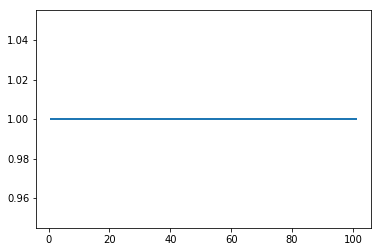

In [15]:
temp_001 = [row[3] for row in restruc_with_ind]
temp_002 = [row[7] for row in restruc_with_ind]
temp001_ar = np.array(temp_001)
temp002_ar = np.array(temp_002)
plt.plot(temp002_ar,temp001_ar)
plt.show()

$\uparrow$ <font size='4'>A straight line?</font> Now that some sort of normalization and restructuring was complete, was it useful?

No. I'd missed something. I needed to stop and reconsider how to normalize the data in order to be able to visualize things, and extract the answers posed.

- We release the cursor, and close the connection we've been using until now.

In [14]:
tcur.close()

In [15]:
temp_connect.close()

#### Data Smoothing - Part 2

My previous normalization fell short when I tried to make a visualization. Part of this had to do with the structure of the reformatted data. I decided that by making additional tables from various resturcuring results, I could speed up my process.

In all, I created 4 additional tables. Each one an iteration on thinking about how to represent the underlying data, such that the questions could be answered thoroughly, and visualized in a way that makes sense.

 - As the first question deals with salary, the queries on `struc2` do aggregation around current/previous and future/expected salary.

In [5]:
struc2_table = make_table(tablename='struc2')
t2cur = struc2_table.cursor()

In [6]:
agg01 = """
select
    count(coalesce(struc2.curr_salary,0)),
    count(coalesce(struc2.fut_salary,0)),
    struc2.curr_sal_cat,
    struc2.fut_sal_cat
from struc2
group by 3,4
"""
agg02 = """
select
    count(coalesce(struc2.curr_salary,0)),
    count(coalesce(struc2.fut_salary,0)),
    struc2.curr_sal_cat,
    struc2.fut_sal_cat
from struc2
where (struc2.curr_sal_cat is not null)
    and (struc2.fut_sal_cat is not null)
group by 3,4
"""

t2cur.execute(agg01)
res01 = t2cur.fetchall()
t2cur.execute(agg02)
res02 = t2cur.fetchall()

In [39]:
res01[0]

(627, 627, None, None)

In [40]:
res02[0]

(118, 118, 0, 0)

In [41]:
res02[:10]

[(118, 118, 0, 0),
 (12, 12, 0, 1),
 (39, 39, 0, 1001),
 (25, 25, 0, 2001),
 (27, 27, 0, 3001),
 (4, 4, 0, 5001),
 (11, 11, 0, 6001),
 (24, 24, 1, 0),
 (98, 98, 1, 1),
 (469, 469, 1, 1001)]

In [42]:
cs = [x[0] for x in res02]
fs = [x[1] for x in res02]
cc = [x[2] for x in res02]
fc = [x[3] for x in res02]

- Viz.A __First concrete visualization__

This plot _attempts_ to show the distribution and relation betwen current and epxected salary

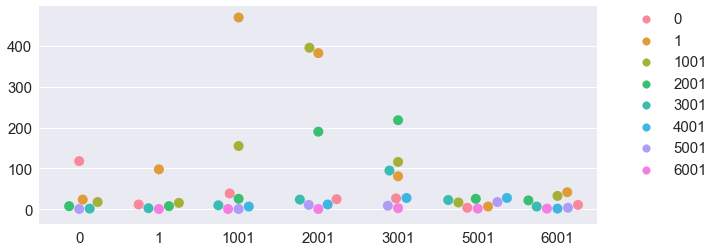

In [43]:
plt.figure(figsize=(10,4))
sns.set(font_scale=1.5)
sns.swarmplot(x=fc,y=cs,hue=cc,size=10)
plt.legend(bbox_to_anchor=(1.05,1),loc=2, borderaxespad=0.)
plt.show()

- Viz.B __Second concrete visualization__

This plot also tries to show the distribution and relation betwen current and epxected salary

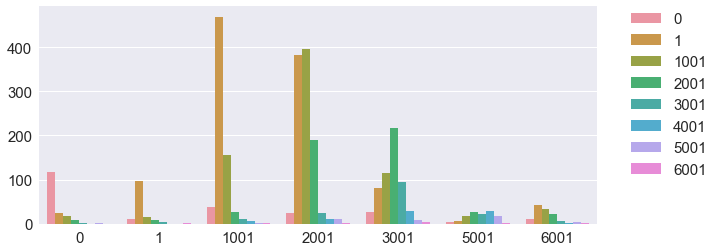

In [44]:
plt.figure(figsize=(10,4))
sns.set(font_scale=1.5)
sns.barplot(x=fc,y=cs,hue=cc)
plt.legend(bbox_to_anchor=(1.05,1),loc=2, borderaxespad=0.)
plt.show()

__ Viz.A and Viz.B__ description, and what's wrong

Description: In both plots, we have __future salary__ categories on the $X$-axis and __totals__ on the $Y$-axis. The colors, represent __current/previous salary__.
- For example, 2001 = "2000 - 3000 EUR". 
  - And around 198 people who would like "2000-3000 EUR" in the future, also currently make "2000-3000 EUR"
  
What's wrong: It's colorful but confusing. Given the number of categoires, we should represent each separately.

At this point, we've achieved smoothing and normalization of the data and now look to manipulaitons that give us answers.

- Looking into Pandas crosstabs, they seem to push us forward.
- After the attempt below, table `struc11` is made in the SQL db, and we visualize the distributions

---
<div class="alert alert-block alert-success"><font face='Avenir' size=5>
<b>Start:</b> With a bulk of the hiccups out of the way, we begin answering the initial questions.</font>
</div>

---

In [18]:
resdf = pd.DataFrame(res02)
resdf.columns = ['cur_sal','fut_sal','cur_class','fut_class']
resdf[:10]

,cur_sal,fut_sal,cur_class,fut_class
0,118,118,0,0
1,12,12,0,1
2,39,39,0,1001
3,25,25,0,2001
4,27,27,0,3001
5,4,4,0,5001
6,11,11,0,6001
7,24,24,1,0
8,98,98,1,1
9,469,469,1,1001


In [19]:
cross01 = pd.crosstab(index=resdf["fut_class"],columns=resdf['cur_class'],values=resdf["cur_sal"], aggfunc=sum)
pd.crosstab(index=resdf["fut_class"],columns=resdf['cur_class'],values=resdf["cur_sal"], aggfunc=sum)

cur_class,0,1,1001,2001,3001,4001,5001,6001
fut_class,,,,,,,,
0,118.0,24.0,18.0,8.0,2.0,NaN,1.0,NaN
1,12.0,98.0,16.0,8.0,3.0,NaN,NaN,1.0
1001,39.0,469.0,155.0,26.0,10.0,7.0,1.0,1.0
2001,25.0,382.0,395.0,190.0,24.0,12.0,11.0,1.0
3001,27.0,81.0,116.0,218.0,95.0,28.0,9.0,3.0
5001,4.0,7.0,17.0,26.0,23.0,28.0,18.0,2.0
6001,11.0,42.0,33.0,22.0,7.0,2.0,4.0,2.0


In [61]:
cross01.T[1001]

cur_class
0        39.0
1       469.0
1001    155.0
2001     26.0
3001     10.0
4001      7.0
5001      1.0
6001      1.0
Name: 1001, dtype: float64

<BarContainer object of 8 artists>

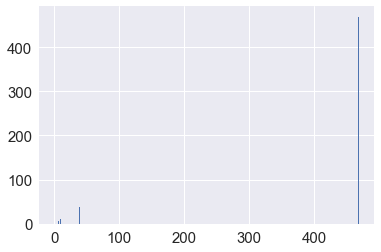

In [62]:
plt.bar(cross01.T[1001],cross01.T[1001])
plt.show()

- With the learnings from the first crosstab, we make the new `struc11` table and query from it

In [64]:
titles01 = ['No Ans','<1k','<2k','<3k','<4k','<5k','<6k','6k+']
margins = [0,1,1001,2001,3001,4001,5001,6001]

In [60]:
# connect to tabl struc11 and return the connection, then the cursor
struc11_table = make_table(tablename='struc11')
t11cur = struc11_table.cursor()

In [61]:
agg11_01 = """
select
    struc11.curr_salary,
    struc11.fut_salary,
    count(*) as subt

from struc11
group by 1,2
"""

In [62]:
t11cur.execute(agg11_01)
res11_01 = t11cur.fetchall()
# release cursor and close db connection
t11cur.close()
struc11_table.close()
# --------
res11_01df = pd.DataFrame(res11_01,columns=['curr sal','futr sal','subtotal'])
res11_01df.head()

,curr sal,futr sal,subtotal
0,None,None,627
1,None,6k+,1
2,None,<1.5k,14
3,None,<1k,6
4,None,<3k,15


In [63]:
cross11_01 = pd.crosstab(index=res11_01df['futr sal'],
                         columns=res11_01df['curr sal'],
                         values=res11_01df['subtotal'],
                         aggfunc=sum)
cross11_01

curr sal,6k+,<1.5k,<1k,<3k,<4k,<5k,<6k,R2A
futr sal,,,,,,,,
6k+,2.0,33.0,42.0,22.0,7.0,2.0,4.0,11.0
<1.5k,1.0,155.0,469.0,26.0,10.0,7.0,1.0,39.0
<1k,1.0,16.0,98.0,8.0,3.0,NaN,NaN,12.0
<3k,1.0,395.0,382.0,190.0,24.0,12.0,11.0,25.0
<4k,2.0,96.0,66.0,169.0,58.0,8.0,2.0,19.0
<5k,1.0,20.0,15.0,49.0,37.0,20.0,7.0,8.0
<6k,2.0,17.0,7.0,26.0,23.0,28.0,18.0,4.0
R2A,NaN,18.0,24.0,8.0,2.0,NaN,1.0,118.0


- Our rows and columns aren't in the desired order, so we reindex them

In [64]:
cross11_01 = cross11_01.reindex(columns=['R2A', '<1k', '<1.5k', '<3k', '<4k', '<5k', '<6k', '6k+'])
cross11_01

curr sal,R2A,<1k,<1.5k,<3k,<4k,<5k,<6k,6k+
futr sal,,,,,,,,
6k+,11.0,42.0,33.0,22.0,7.0,2.0,4.0,2.0
<1.5k,39.0,469.0,155.0,26.0,10.0,7.0,1.0,1.0
<1k,12.0,98.0,16.0,8.0,3.0,NaN,NaN,1.0
<3k,25.0,382.0,395.0,190.0,24.0,12.0,11.0,1.0
<4k,19.0,66.0,96.0,169.0,58.0,8.0,2.0,2.0
<5k,8.0,15.0,20.0,49.0,37.0,20.0,7.0,1.0
<6k,4.0,7.0,17.0,26.0,23.0,28.0,18.0,2.0
R2A,118.0,24.0,18.0,8.0,2.0,NaN,1.0,NaN


In [65]:
cross11_01 = cross11_01.reindex(index=['R2A', '<1k', '<1.5k', '<3k', '<4k', '<5k', '<6k', '6k+'])
cross11_01

curr sal,R2A,<1k,<1.5k,<3k,<4k,<5k,<6k,6k+
futr sal,,,,,,,,
R2A,118.0,24.0,18.0,8.0,2.0,NaN,1.0,NaN
<1k,12.0,98.0,16.0,8.0,3.0,NaN,NaN,1.0
<1.5k,39.0,469.0,155.0,26.0,10.0,7.0,1.0,1.0
<3k,25.0,382.0,395.0,190.0,24.0,12.0,11.0,1.0
<4k,19.0,66.0,96.0,169.0,58.0,8.0,2.0,2.0
<5k,8.0,15.0,20.0,49.0,37.0,20.0,7.0,1.0
<6k,4.0,7.0,17.0,26.0,23.0,28.0,18.0,2.0
6k+,11.0,42.0,33.0,22.0,7.0,2.0,4.0,2.0


In [66]:
colista = ['R2A', '<1k', '<1.5k', '<3k', '<4k', '<5k', '<6k', '6k+',"All"]
cross11_01b = pd.crosstab(index=res11_01df['futr sal'], columns=res11_01df['curr sal'],
                         values=res11_01df['subtotal'], aggfunc=sum,
                         normalize='columns', margins=True)
cross11_01b = cross11_01b.reindex(columns=colista)
cross11_01b = cross11_01b.reindex(index=colista[:-1])
cross11_01b

curr sal,R2A,<1k,<1.5k,<3k,<4k,<5k,<6k,6k+,All
futr sal,,,,,,,,,
R2A,0.500000,0.021759,0.024000,0.016064,0.012195,0.000000,0.022727,0.0,0.059334
<1k,0.050847,0.088849,0.021333,0.016064,0.018293,0.000000,0.000000,0.1,0.047883
<1.5k,0.165254,0.425204,0.206667,0.052209,0.060976,0.090909,0.022727,0.1,0.245663
<3k,0.105932,0.346328,0.526667,0.381526,0.146341,0.155844,0.250000,0.1,0.360861
<4k,0.080508,0.059837,0.128000,0.339357,0.353659,0.103896,0.045455,0.2,0.145732
<5k,0.033898,0.013599,0.026667,0.098394,0.225610,0.259740,0.159091,0.1,0.054476
<6k,0.016949,0.006346,0.022667,0.052209,0.140244,0.363636,0.409091,0.2,0.043373
6k+,0.046610,0.038078,0.044000,0.044177,0.042683,0.025974,0.090909,0.2,0.042679


- We now have well-labeled data in with the aggregates we want, and can show the distributions.

---
<div class="alert alert-block alert-warning">
$\circ$ <font face='Avenir' size=5>1. What is the distribution of expected net income, in relation to current net income?</font><br>
</div>
  
---

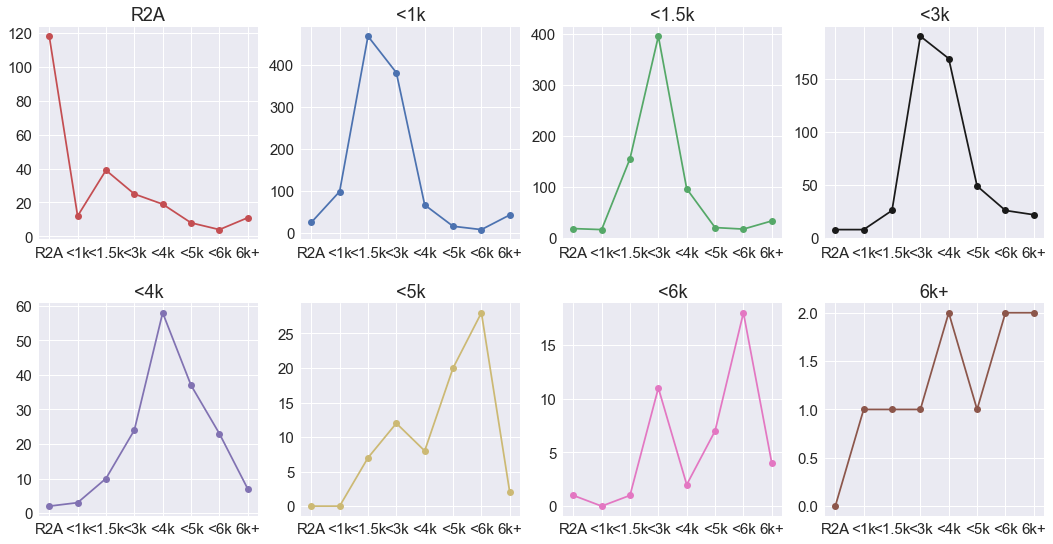

In [67]:
whatcolumn = ['R2A', '<1k', '<1.5k', '<3k', '<4k', '<5k', '<6k', '6k+']
whatcolor = ['r','b','g','k','m','y','tab:pink','tab:brown']

temp_cross11_01 = cross11_01.fillna(value=0, inplace=False) # remove gaps in the plot

sns.set(font_scale=1.5)
fig, ax = plt.subplots(2, 4,figsize=(18,9))

for row in range(2):
    for col in range(4):
        rc_ind = (4*row) + col
        whclm = whatcolumn[rc_ind]
        ax[row,col].plot(temp_cross11_01[whclm], whatcolor[rc_ind], marker='o')
        ax[row,col].set_title(whclm)
plt.subplots_adjust(hspace=0.3)
plt.show()

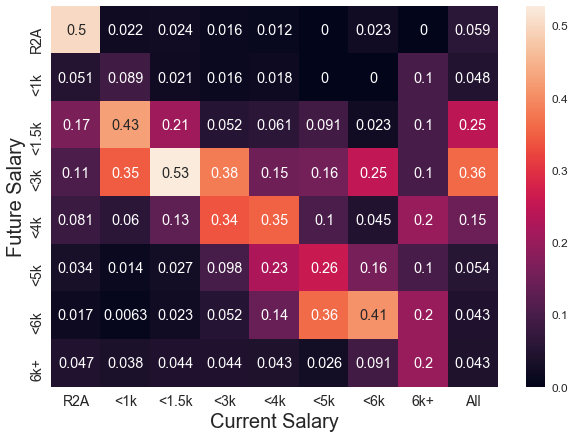

In [52]:
plt.figure(figsize=(10,7))
sns.heatmap(cross11_01b, annot=True)
sns.set(font_scale=1.2)
plt.xlabel("Current Salary",size=20)
plt.xticks(size=14)
plt.ylabel("Future Salary", size=20)
plt.yticks(size=14)
plt.show()

<div class="alert alert-block alert-warning">
<b><font face='Avenir' size='3'>Answer/Discussion:</font></b></div>
<font face="Avenir" size='3'><br><br><b>2x4 plot:</b><br>
Each graph above reprsents the distribution of responses for __one__ category of "current or previous monthly net salary".<br></font>

<font face='Avenir' size='3'><br>What each graph shows, it the expectation for future salaries, based on current salary. Each graph therfore, is a column from the crosstab shown earlier. As arranged, the top-left graph is for `R2A`, which means, 'refused to answer'. This includes respondents who did chose not to disclose their current/previous salary. Many of them (118) did not indicate what they'd like to be paid in their next job. However, some did, and the highest category for this was the category `1000 to 1500 EUR`.<br></font>

<font face='Avenir' size='3'><br>The graphs (as indicated by title) progress from right to left, and from top row to bottom row. For each plot, within a graph, a steep point later in the plot indicates a preference for future pay that exceeds current/previous pay.<br></font>

<font face='Avenir' size='3'><br>This can best be seen int the `<1.5k` graph. In this plot for this graph, there is a peak at `<3k`. Indicating that more respondents currently earning `1000 - 1500 EUR` want to make `2001 - 3000 EUR` in the future.<br></font>

<font face="Avenir" size='3'><br><br><b>Heatmap:</b><br>
This plot is well-labeled. The decimal values shown represents the ratio of the Y-axis attribute, in each X-axis column. We can see that 53% of repsondents currently earning `1001 to 1500 EUR`, would like to earn `2001 to 3000 EUR` in their future job/`sought-after job`.
</font>

<font face='Avenir' size='3'>By default, the crosstab drops data where either the row or column was NULL. This means all the data related to people who didn't respond (different from "refuse to respond") on their current or future salary, is not considered.<br></font>

<font face='Avenir' size='3'><br>__Note-1:__ When running this process a second time, and specifying `where (struc11.are_you_looking = 'yes') or  (struc11.do_you_work = 'yes')`, the final results are exactly the same. Only the count of people not responsing for both caregories, descreases from `627` to `155`.<br></font>

<font face='Avenir' size='3'><br>__Note-2:__ The crosstab values can be normalized by columns using `x = preprocessing.StandardScaler()`, `y = x.fit_transform(someCrosstab)`, `z = pd.DataFrame(y)`. The plot is similar, but our original plot is easier to read raw values from and interpret.</font>

---
The format of the next two questions implied that something like regression would be useful. For this reason, the dataset was transformed again. The new table created,`logreg01` encoded every single column into an integer value, while still retaining our "grouped" columns from before.

- To compare "desire to earn more" and "willingness to commute" we should use logistic regression.

Layout of the `survey.logreg01` table
- Our columns of interest will be `logreg01.fut_how_far` and `logreg01.fut_salary`.
- We will omit rows where either of the above is `NULL` or `do_you_work` is `NULL`

| Column Name | Type of Data
|-----|
| id |                1-3692                  |
| are_you_looking   | 1,0                     |
| do_you_work       | 1/0/2 : yes/no/NULL     |
| curr_how_far      | 6-1, with NULL as 0     |
| fut_how_far       | 6-1, with NULL as 0     |
| curr_salary       | 8-1, with NULL as 0     |
| fut_salary        | 8-1, with NULL as 0     |
| ever_worked       | 1/0/2                   |
| would_move_closer | 1/2/0                   |
| city_size         | 7-1                     |
| gender            | 1/0 : male/female       |
| age               | 1-6                     |
| education         | 1-4                     |
| subtotal          | 1                       |

In [45]:
logreg_conn = make_table(tablename='logreg01')
lr_cur = logreg_conn.cursor()

In [46]:
lrq_01 = """
select
    logreg01.fut_how_far,
    logreg01.fut_salary
from logreg01
where logreg01.do_you_work <> 2
    and logreg01.fut_how_far <> 0
    and logreg01.fut_salary <> 0
"""

In [47]:
lr_cur.execute(lrq_01)
res_lr_cur_01 = lr_cur.fetchall()
# release cursor and close db connection
lr_cur.close()
logreg_conn.close()
# --------
logregdf_01 = pd.DataFrame(res_lr_cur_01,columns=['futr dist','futr sal'])
print(len(res_lr_cur_01)," records")
logregdf_01.head()

2871  records


,futr dist,futr sal
0,3,4
1,1,4
2,1,3
3,4,4
4,3,3


In [48]:
X_train, X_test, y_train, y_test = train_test_split(logregdf_01["futr sal"], 
                                                    logregdf_01["futr dist"],
                                                    test_size=0.3)
print(len(X_train), len(X_test))

2009 862


In [49]:
single_feature_Xtrain = np.array(X_train).reshape(-1,1)
single_feature_Xtest = np.array(X_test).reshape(-1,1)

In [50]:
logisModel = LogisticRegression()
logisModel.fit(single_feature_Xtrain, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [51]:
logisModel.coef_

array([[-0.26516705],
       [-0.12401945],
       [ 0.05839073],
       [ 0.20028963],
       [ 0.1709831 ],
       [ 0.36026524]])

In [52]:
print("Training score: {}".format(logisModel.score(single_feature_Xtrain, y_train)),
      "Testing Score: {}".format(logisModel.score(single_feature_Xtest, y_test)) ,sep='\n')

Training score: 0.30662020905923343
Testing Score: 0.3190255220417633


$\uparrow$ We can see by the model score, that desired salary is not a good predictor of willingness to commute.

In [27]:
pred_commute = logisModel.predict(single_feature_Xtest)

- The confusion matrix also shows how weak the model is

In [53]:
conf_matrix_01 = confusion_matrix(y_test, pred_commute)
conf_matrix_01

array([[ 11, 100,  50,   0,   0,   0],
       [ 22, 164,  83,   0,   0,   0],
       [ 14, 154,  80,   0,   0,   0],
       [  5,  98,  35,   0,   0,   0],
       [  0,  14,   3,   0,   0,   0],
       [  1,  20,   8,   0,   0,   0]])

- Finally, we predict Acceptable Commute, over the full set of Desired Salaries.
- Then we check the prediction power of the model against the true Acceptable Commute responses.

In [54]:
X_future_salary = np.array(logregdf_01['futr sal']).reshape(-1,1)
full_pred_commute = logisModel.predict(X_future_salary)
print(classification_report(logregdf_01['futr dist'],full_pred_commute))

             precision    recall  f1-score   support

          1       0.22      0.06      0.10       625
          2       0.33      0.71      0.45       864
          3       0.29      0.30      0.30       792
          4       0.00      0.00      0.00       437
          5       0.00      0.00      0.00        60
          6       0.00      0.00      0.00        93

avg / total       0.23      0.31      0.24      2871



/Users/revit/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


We can also use the Spearman correlation, because both columns in question are ordinal, and thus something we can rank. Hence the correation is often called the "rank-order" correlation.

The return value of around $24.9\%$ implies a weak monotonic relationship between Desired Salary and Acceptable Commute. We can use this as a second test and conclusion.

In [55]:
def spear_check(var1, var2):
    sp_coeff, pval = spearmanr(var1,var2)
    return sp_coeff, pval
spear_check(logregdf_01['futr sal'],logregdf_01['futr dist'])

(0.24938857599336814, 5.8827108585707032e-42)

---

<div class="alert alert-block alert-warning">
$\circ$ <font face='Avenir' size=5>2. What is the correlation between the desire to earn more and the possibility of a longer commute?</font><br>
</div>

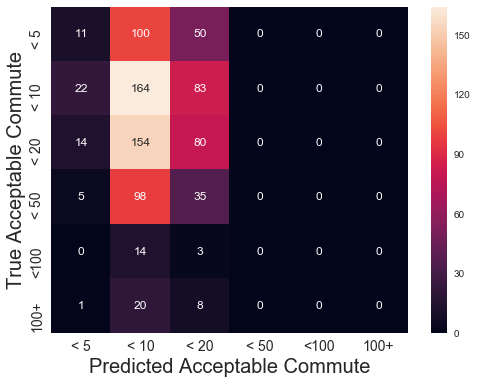

In [111]:
commute_labels = ["< 5","< 10","< 20","< 50","<100","100+"]
commute_loctns = np.array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
y_commute_loctns = np.array([0, 1, 2, 3, 4, 5])
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_01, annot=True, fmt='g', yticklabels =commute_labels)
sns.set(font_scale=1)
plt.xlabel("Predicted Acceptable Commute",size=20)
plt.xticks(commute_loctns,commute_labels,size=14)
plt.ylabel("True Acceptable Commute", size=20)
plt.yticks(size=14)
#plt.Axes.set_yticklabels(labels=commute_labels)
#plt.yticks(commute_loctns,commute_labels,size=14)
plt.show()

<div class="alert alert-block alert-warning">
<b><font face='Avenir' size='3'>Answer/Discussion:</font></b></div>

<font face="Avenir" size='3'><br><br><b>Via Logistic Regression:</b><br>
Our logistic model uses the encodings for "How much would you like to get monthly?" as a single, dependent variable to predict encodings "How far are you able to commute?" We use logistic instead of linear regression, since the data involved are categorical, both in case of input and output. After training the model, we take a look at its scoring, and how well it scores on the test data (a holdout of 30% of the dataset). The model scores around $30\%$. We interpret this as telling us our dependent variable is a poor predictor of the output categories. The model report shows the precision, recall and other metrics about the model. However, we can see and guage the performance visually, by illustrating the <b>confusion matrix</b> - a comparison of actual to predicted values.<br><br>
</font>
$\Rightarrow$ <font face="Avenir" size='3'>In the confusion matrix, we'd expect to see a bright, highlighted diagonal; along with off-diagonal elements close to zero. This would mean that nearly all Predicted values match the Actual values. However, what we see instead, especially in the `< 10km` and `< 20km` categories are off-diagonal hotspots. For example, the model predicted `5 to 10 km` in 100 cases, where `less than 5km` was the <u>actual</u> response. This _highlights_ (literally and figuratively) the poor model performance, and thus the low correlation between the two variables. </font>

<font face="Avenir" size='3'><br><br><b>Via Spearman Rank-Order Correlation:</b><br>
Why use this measure? Normal correlation works for interval and ratio data that fit some assumptions - such as being similarly spaced. The data we are using is ordinal at best.
    
The interpretation is similar, but doesn't measure a _linear_ relationship - rather a _monotonic_ relationship. Based on the caclucated value, __"Desire to Earn More"__ and __"Possibility of a Longer Commute"__ only move in the same direction with a strenth of $0.24$ on a -1 to 1 scale. In other words, they are $24\%$ correlated. This is a weak correlation, and not one that can be used reliably for prediction.
</font>

---

- Finally, we can address the factors involved in willingness to move closer to work.

When we think of factors and their importance, then the idea of Pricinal Component Analysis comes to mind. This is similar to both regression and clustering. However, it turns out PCA is more about determining which factors separate our respondents into similar clusters, and how strongly those factors affect the separation. This isn't the question we're trying to answer, but an interesting one.

If we want to understand influences on willigness to move lcoser to work, then this value has to be our target. We can use multi-dimensioal logistic regression (since everything is categorical), to find out which dimensions are more explanatory than others.

We will use the `logreg01` table, and only consider records without certain `NULL`s:
- `would_move_closer` $\neq$ 2 (explicit exclusion)
- `do you work` $\neq$ 2 (implicit exclusion)

Of course! If we are trying to predict willingness to move closer to work, we exclude records where that response was `NULL`.

By the fist exclusion, all records where "Do you work currently?" was not answered, are also exlcuded.

In [7]:
logreg_conn = make_table(tablename='logreg01')
lr_cur = logreg_conn.cursor()

In [8]:
lrq_02 = """
select
       are_you_looking,
       do_you_work,
       curr_how_far,
       fut_how_far,
       curr_salary,
       fut_salary,
       ever_worked,
       would_move_closer,
       city_size,
       gender,
       age,
       education
from logreg01
where logreg01.would_move_closer <> 2
"""

In [9]:
lr_cur.execute(lrq_02)
res_lr_cur_02 = lr_cur.fetchall()
# release cursor and close db connection
lr_cur.close()
logreg_conn.close()
# --------
temp_colist = ('are_you_looking','do_you_work','curr_how_far',
               'fut_how_far','curr_salary','fut_salary','ever_worked',
               'would_move_closer','city_size','gender','age','education')

movecloser_df = pd.DataFrame(res_lr_cur_02,columns=temp_colist)
print(len(res_lr_cur_02)," records")
movecloser_df.head()

3212  records


,are_you_looking,do_you_work,curr_how_far,fut_how_far,curr_salary,fut_salary,ever_worked,would_move_closer,city_size,gender,age,education
0,1,0,1,3,3,4,1,0,2,0,4,2
1,1,0,1,1,4,4,1,0,5,1,6,2
2,1,0,1,1,2,3,1,0,4,0,3,2
3,1,1,1,4,3,4,2,0,2,0,3,4
4,1,0,1,3,2,3,1,0,3,0,3,4


$\bullet$ quickly check for independence between our dimensions

$\ast$ Since `are_you_looking` is always $1$ in our query results it will not be used.  
&nbsp; &nbsp; $\circ$ Not only is an unchanging varibale useless, the Spearman Correlation function isn't meant for this type of data.

In [76]:
dims_only_list = list(range(12)) # we have 12 columns - index 0 - 11
dims_only_list.remove(7) # index 7 is our target
dims_only_list.remove(0) # are_you_looking is always 1. It doesn't vary.
dims_only_list

[1, 2, 3, 4, 5, 6, 8, 9, 10, 11]

In [16]:
mc_dims_only = movecloser_df.iloc[:,dims_only_list]
mc_dims_only.head()

,do_you_work,curr_how_far,fut_how_far,curr_salary,fut_salary,ever_worked,city_size,gender,age,education
0,0,1,3,3,4,1,2,0,4,2
1,0,1,1,4,4,1,5,1,6,2
2,0,1,1,2,3,1,4,0,3,2
3,1,1,4,3,4,2,2,0,3,4
4,0,1,3,2,3,1,3,0,3,4


In [17]:
mc_target = movecloser_df.loc[:,["would_move_closer"]].values
mc_target

array([[0],
       [0],
       [0],
       ..., 
       [0],
       [1],
       [1]])

In [51]:
# for each pair of columns, get a correlation score
# if the corr is too high, we don't need to use both in our regression

def pairwise_independence_check(some_df):
    df_colist = list(some_df.columns)
    pairs_list = [combo for combo in combinations(list(mc_dims_only.columns),2)]
    # [('are_you_looking', 'do_you_work'), ('are_you_looking', 'curr_how_far'), etc]
    def pairedtionary(prz_lst):
        dempty = {}
        for j in prz_lst:
            primkey = j[0]
            if primkey not in dempty.keys():
                dempty[primkey] = {j[1]:0}
            else:
                scndkey = j[1]
                if scndkey not in dempty[primkey].keys():
                    dempty[primkey][scndkey] = 0
        return dempty
    result_dict = pairedtionary(pairs_list)
    
    for col_pair in pairs_list:
        prim, scnd = col_pair[0], col_pair[1]
        spear_corr = spearmanr(some_df[prim],some_df[scnd])[0]
        scshift_round = int(round(100000 * spear_corr,0))
        spear_rounded = scshift_round/100000
        result_dict[prim][scnd] = spear_rounded
    
    return result_dict

- We inspect the dictioary below for large correlations

In [72]:
from pprint import pprint
pprint(pairwise_independence_check(mc_dims_only), width=100,indent=1)

{'age': {'education': 0.0548},
 'city_size': {'age': 0.06558, 'education': 0.05711, 'gender': -0.01456},
 'curr_how_far': {'age': 0.08795,
                  'city_size': -0.14186,
                  'curr_salary': 0.30457,
                  'education': 0.00056,
                  'ever_worked': 0.22436,
                  'fut_how_far': 0.38146,
                  'fut_salary': 0.25517,
                  'gender': 0.12314},
 'curr_salary': {'age': 0.25,
                 'city_size': 0.06778,
                 'education': 0.02916,
                 'ever_worked': 0.19544,
                 'fut_salary': 0.52763,
                 'gender': 0.31696},
 'do_you_work': {'age': 0.0806,
                 'city_size': 0.04163,
                 'curr_how_far': 0.13161,
                 'curr_salary': 0.10131,
                 'education': 0.10164,
                 'ever_worked': 0.9605,
                 'fut_how_far': 0.09891,
                 'fut_salary': 0.22899,
                 'gender': 0.07734}

The lagest correlations are between

- current commute & ever worked ~ 22%
- current & future commute ~ 38%
- current commute & future salary ~ 25%


- current salary & age  ~ 25%
- current & future salary ~ 52%
- current salary & gender ~ 31%


- __currently working & ever worked__ ~ 96%
- currently working & future salary ~ 23%


- future commute & city size ~ $-$22%
- future commute & future salary ~ 39%


- future salary & gender ~ 30%

We would expect a relaiton between current pay and future expectations of pay. These two factors ahve the 2nd highest correlation, at about 52%. However, I wouldn't consider one a great proxy for the other.

On the other hand, `Have you ever worked before?` gets a 96% Spearman correlation with `Do you work currently?`. We don't need to consider both or these in the logstic regression. More imprtantly, when checking the SQL `logreg01` table, we find something interest, which we can cosider another type of __noise__.

#### <u>Noise - data incongruence</u>

$\Rightarrow$ There are `1093` records with a `2` (i.e. `NULL`) for `ever_worked`, but `1` (`yes`) for `do_you_work` $\Leftarrow$

It's impossible to currently be working, and never have worked before. While literally "before" can mean _before this job_, we understand that ths question is meant to incude your current job, even if your current job is your first job.

Sine the issue is with the `ever_worked` column, and this column already has a 96% correlation with `do_you_work`, we will drop `ever worked` from the analysis of factors influencing willingenes to move closer to work.

In [82]:
# get rid of the index for ever_worked
log_reg_dims_list = [n for n in dims_only_list] # forcing a new list
log_reg_dims_list.remove(6)
mc_logreg_dims_only = movecloser_df.iloc[:,log_reg_dims_list]
mc_logreg_dims_only.head()

,do_you_work,curr_how_far,fut_how_far,curr_salary,fut_salary,city_size,gender,age,education
0,0,1,3,3,4,2,0,4,2
1,0,1,1,4,4,5,1,6,2
2,0,1,1,2,3,4,0,3,2
3,1,1,4,3,4,2,0,3,4
4,0,1,3,2,3,3,0,3,4


- we scale the data

In [91]:
tmpcols = list(mc_logreg_dims_only.columns)
dtscaler = preprocessing.StandardScaler()
scaled_vals = dtscaler.fit_transform(mc_logreg_dims_only) 
mc_logreg_scaled_dims = pd.DataFrame(scaled_vals, columns=tmpcols)
mc_logreg_scaled_dims.tail()

,do_you_work,curr_how_far,fut_how_far,curr_salary,fut_salary,city_size,gender,age,education
3207,-0.718697,-0.083761,0.498214,-1.176970,0.169440,1.508551,-0.983940,-1.054890,1.437735
3208,-0.718697,0.618696,-0.944113,-0.490119,-0.367286,0.130432,1.016322,1.088703,0.370482
3209,-0.718697,-0.786218,-0.944113,-1.176970,-1.977464,-0.328941,-0.983940,1.088703,-0.696772
3210,1.391407,1.321152,-0.222950,-0.490119,-0.367286,-1.247687,-0.983940,1.088703,-0.696772
3211,-0.718697,-0.786218,0.498214,-0.490119,0.169440,-1.247687,-0.983940,-1.054890,-0.696772


In [133]:
X_train, X_test, y_train, y_test = train_test_split(mc_logreg_scaled_dims, mc_target, test_size=0.1)
print(len(X_train), len(X_test))

2890 322


In [114]:
y_train = y_train.ravel()
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [115]:
proximity_lgMdl = LogisticRegression()
proximity_lgMdl.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [137]:
proximity_lgMdl.coef_

array([[ 0.07919702,  0.07332206,  0.22756743, -0.01845092,  0.16727217,
        -0.10918477,  0.20453212, -0.2855298 ,  0.14122777]])

In [156]:
np.sum(proximity_lgMdl.coef_)

0.47995308008760806

In [127]:
print("Training score: {}".format(proximity_lgMdl.score(X_train, y_train)),
      "Testing Score: {}".format(proximity_lgMdl.score(X_test, y_test)),
      "Combined Score: {}".format(proximity_lgMdl.score(mc_logreg_scaled_dims,mc_target))
      ,sep='\n')

Training score: 0.7290657439446366
Testing Score: 0.6925465838509317
Combined Score: 0.7254047322540473


In [128]:
mc_test_pred = proximity_lgMdl.predict(X_test)
mc_full_pred = proximity_lgMdl.predict(mc_logreg_scaled_dims)

conf_matrix_mctest = confusion_matrix(y_test, mc_test_pred)
conf_matrix_mcfull = confusion_matrix(mc_target, mc_full_pred)

print(conf_matrix_mctest,'\n')
print(conf_matrix_mcfull)

[[213   6]
 [ 93  10]] 

[[2237   43]
 [ 839   93]]


$\uparrow$ The ideal case would be zeros in row-1,column-2 and row-2,column-1.  
Based on the confusion matrices for the test set and full set, our model did some things well, others not so well.

- We show the confusion matrix for regression on all the data below, to further quantify our results.

In [132]:
print(classification_report(mc_target,mc_full_pred))

             precision    recall  f1-score   support

          0       0.73      0.98      0.84      2280
          1       0.68      0.10      0.17       932

avg / total       0.71      0.73      0.64      3212



---

<div class="alert alert-block alert-warning">
$\circ$ <font face='Avenir' size=5>3. What key factor determines the tendency to move closer to work?</font><br>
</div>

<div class="alert alert-block alert-warning">
<b><font face='Avenir' size='3'>Answer/Discussion:</font></b></div>

<font face="Avenir" size='3'><br><br><b>Logistic Regression: Coefficients</b><br>
Based on the regression coeffecients, contribution to the binary response of "Are you keen on moving closer to your work place?" is spread out over many factors. However, 3 factors do stand out with the highest contributions.<br>
<br>
$\circ$ 3rd strongest factor: <u>Gender</u> - (coeff 0.20453212)
<br> &nbsp; &nbsp; - Female was encoded as 0, and male as 1. Thus, being male improves the chance our model will predict "yes" on "keen to move".
<br><br>
$\ast$ 2nd strongest factor: <u>Acceptable Commute Distance (Sought-after Job)</u> - (coeff 0.22756743)
<br> &nbsp; &nbsp; - Someone willing to commute further for work, is also more prone to move closer. It is a benefit to them.
<br><br>
$\star$ Strongest factor: <u>Age</u> - (coeff $-$0.2855298)
<br> &nbsp; &nbsp; - Age is the key factor determining the tendency to move closer to work.
<br> &nbsp; &nbsp; - The coefficient is negative. This implies that as age increases, there's less tendency to move closer to work.
<br></font>

<font face="Avenir" size='3'><br><br><b>Logistic Regression: Precision and Recall</b><br>
The `classification_report` reminds us to take the results "with a grain of salt," as we say in the US.<br>
$\circ$ Precision is the ratio of correct predictions to total predictions of that outcome.<br>
&nbsp; - Our Precision for "<b>Not</b> keen on moving closer to your work place" is only 73%.<br>
&nbsp; - Meaning 26% of the time, we predicted this, we were wrong.<br>
&nbsp; - The same arguments follow for <i>Yes</i> "keen on moving closer to your work place" - at 68% precision.<br>
<br>
$\circ$ Recall is the ratio of well-predicted outcomes of that type, to the actual amount of those outcomes.<br>
&nbsp; - At 98%, the model is great at predicting "Not keen to move", when that's the true response.<br>
&nbsp; - However, at 10%, the model is very poor at predicting "keen to move" when that's the case.<br>
<br></font>

<font face="Avenir" size='3'>With the recall of category `1` being so low, and the precision for cateogry `1` being moderate, we can't really conclude that our model can determine who <u>would</u> move closer for work. Since that's more important than who would _not_ move closer, the model shouldn't be used.<br>
Its results would misclaffiy those who would move closer incorrectly, more than we'd want. 
</font>

#### __Aside__
---
- Should we run PCA anyway?

We could again use the `logreg01` table, and only consider records without certain `NULL`s:
- `would_move_closer` $\neq$ 2 
- `curr_how_far` $\neq$ 0
- `fut_how_far` $\neq$ 0
- `curr_salary` $\neq$ 0
- `fut_salary` $\neq$ 0

This actually still includes $1032$ people with a `2` encoded (i.e. `NULL`) for `ever_worked`. That seems like it could skew the analysis.  
$\rightarrow$ Therefore, we should check for the key factors, excluding this group of people.  
$\Rightarrow$ However, above we determined `ever_worked` is redundant. We can omit this column from PCA, instead of the affected rows.


- Despite the above, PCA is poorly suited to categorical data that isn't strictly binary.

This make sense. The high-level goal of PCA is to find out "which components lead to the greatest variation/separation of our data". Even with binary data, a 0 or 1, e.g. Male or Female, is already a distinctive slice on the data. It isn't much different for dimensions with a small, finite number of categories. Furthermore, the real goal was achieved above. That goal was to find out influences on "move closer". This isn't what PCA would do. Thus, while I spent quite a bit of time looking into the implementation and conclusions for PCA, it's not what we're looking for, and not well suted to our data.

<div class="alert alert-block alert-info"><font face='Avenir' size=5>
<b>Finish:</b> Answers and reasoning for each question have been given. Thank you!</font>
</div>